In [1]:
pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import missingno as msno
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [3]:
#loading data
df = pd.read_excel('customer_churn_large_dataset.xlsx')

In [4]:
df.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


#The data includes:
#Customers who left – the column is called Churn
#Subscription length in months – the column is called Subscription_Length_Months
#Total usage of internet in GB - the column is called Total_Usage_GB
#And the data of customer information including there name, age gender, location

In [5]:
df.shape

(100000, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  int64  
 1   Name                        100000 non-null  object 
 2   Age                         100000 non-null  int64  
 3   Gender                      100000 non-null  object 
 4   Location                    100000 non-null  object 
 5   Subscription_Length_Months  100000 non-null  int64  
 6   Monthly_Bill                100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  int64  
 8   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 6.9+ MB


In [7]:
df.describe()

,CustomerID,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,44.027020,12.490100,65.053197,274.393650,0.497790
std,28867.657797,15.280283,6.926461,20.230696,130.463063,0.499998
min,1.000000,18.000000,1.000000,30.000000,50.000000,0.000000
25%,25000.750000,31.000000,6.000000,47.540000,161.000000,0.000000
50%,50000.500000,44.000000,12.000000,65.010000,274.000000,0.000000
75%,75000.250000,57.000000,19.000000,82.640000,387.000000,1.000000
max,100000.000000,70.000000,24.000000,100.000000,500.000000,1.000000


In [8]:
df.columns.values

array(['CustomerID', 'Name', 'Age', 'Gender', 'Location',
       'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB',
       'Churn'], dtype=object)

In [9]:
df.dtypes

CustomerID                      int64
Name                           object
Age                             int64
Gender                         object
Location                       object
Subscription_Length_Months      int64
Monthly_Bill                  float64
Total_Usage_GB                  int64
Churn                           int64
dtype: object

# Check missing values

In [10]:
df.isnull().sum()

CustomerID                    0
Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

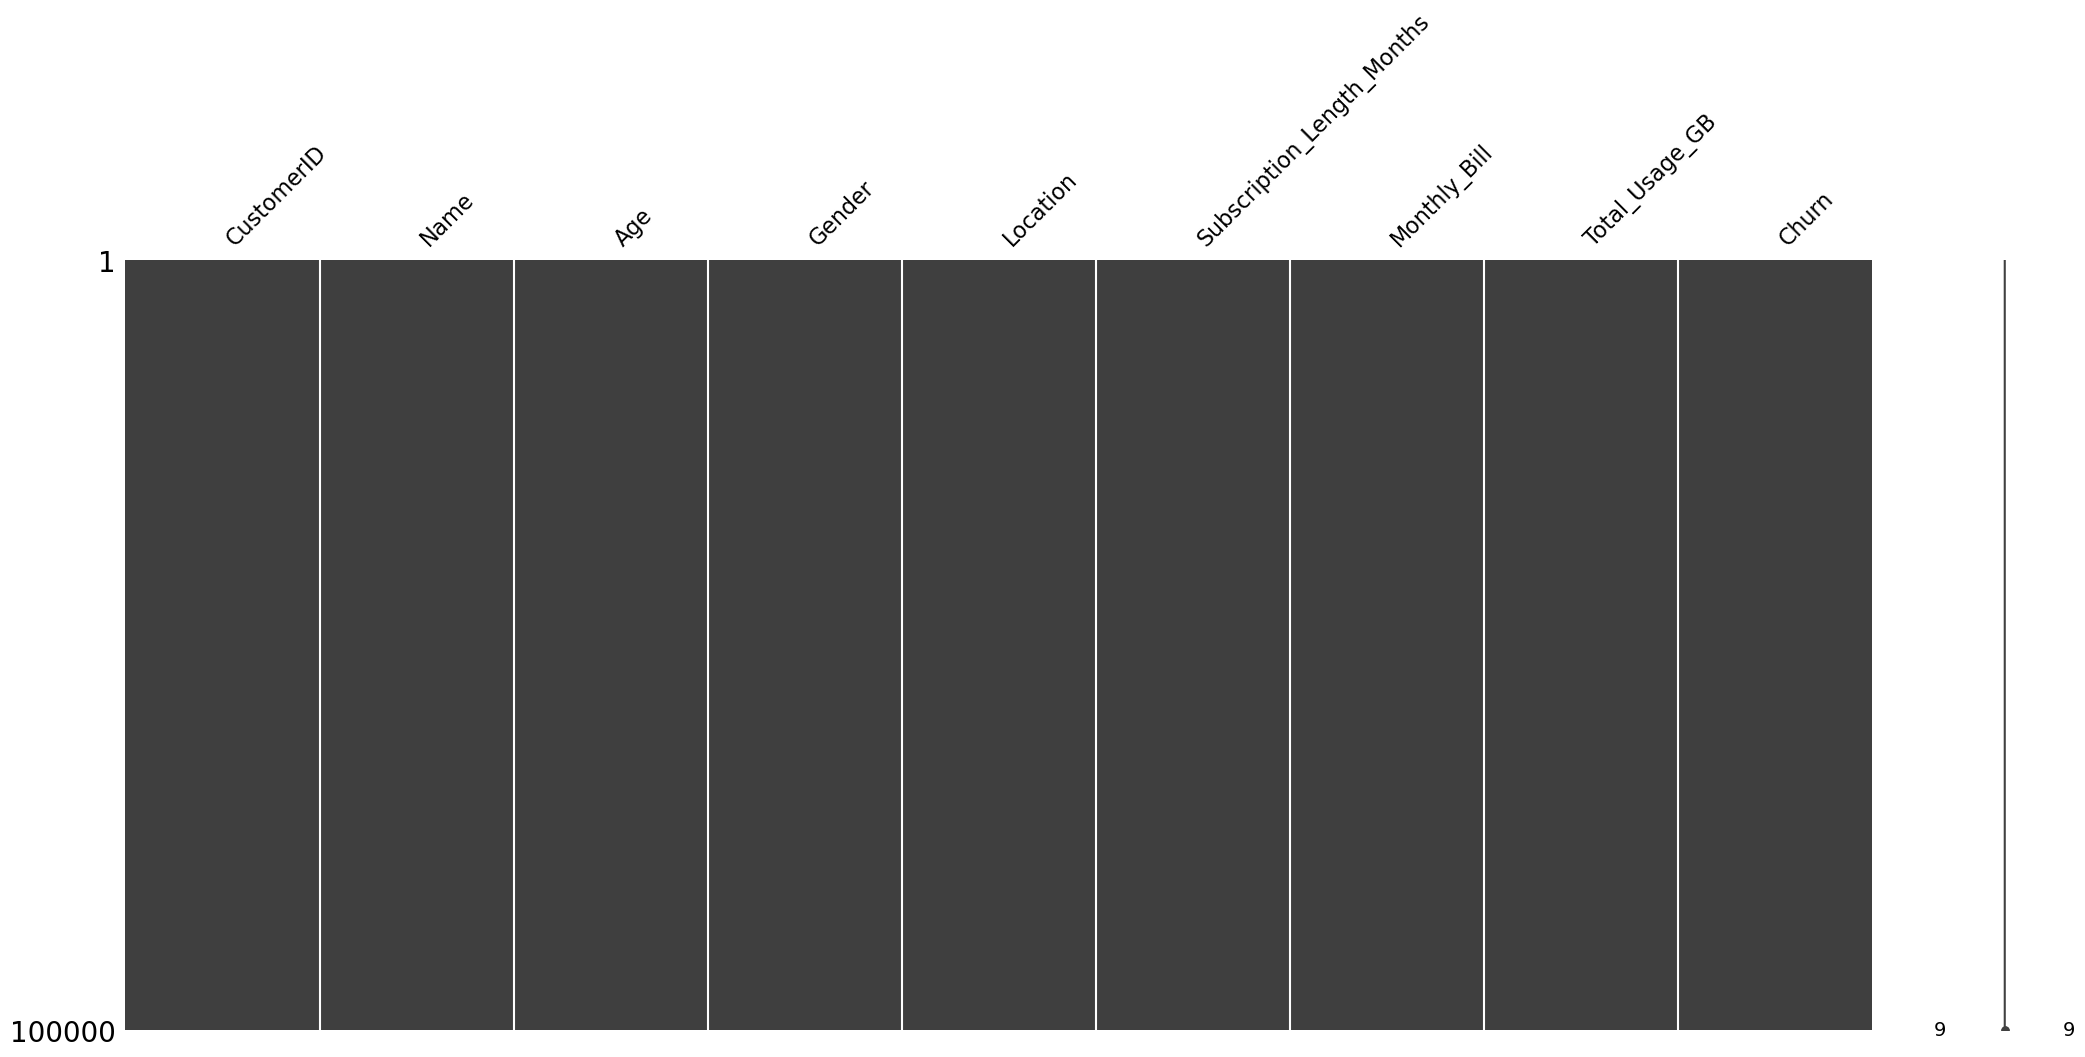

In [11]:
# Visualize missing values
msno.matrix(df)
plt.show()

#There are no null values

# Data preprocessing

In [12]:
df.drop(['CustomerID','Name'], axis=1, inplace=True)

In [13]:
df.head()

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,Male,Los Angeles,17,73.36,236,0
1,62,Female,New York,1,48.76,172,0
2,24,Female,Los Angeles,5,85.47,460,0
3,36,Female,Miami,3,97.94,297,1
4,46,Female,Miami,19,58.14,266,0


# Data visualization

<AxesSubplot:>

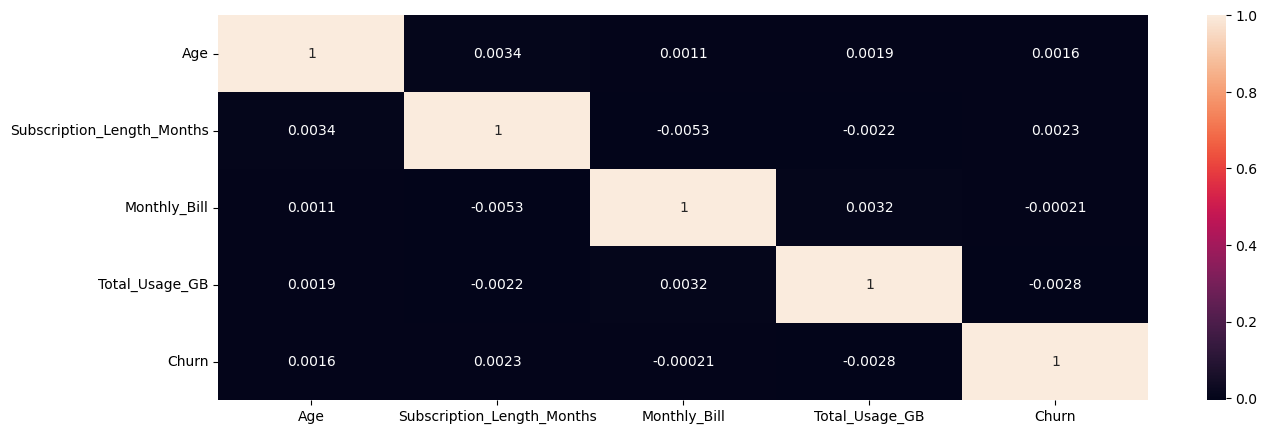

In [14]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(),annot=True)

<Figure size 5000x5000 with 0 Axes>

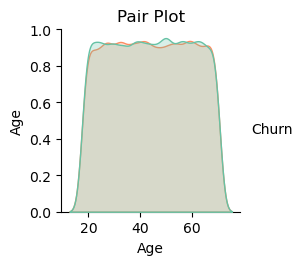

In [15]:
plt.figure(figsize=(50,50))
sns.pairplot(df[['Age','Churn']], hue='Churn', palette='Set2')
plt.title('Pair Plot')
plt.show()

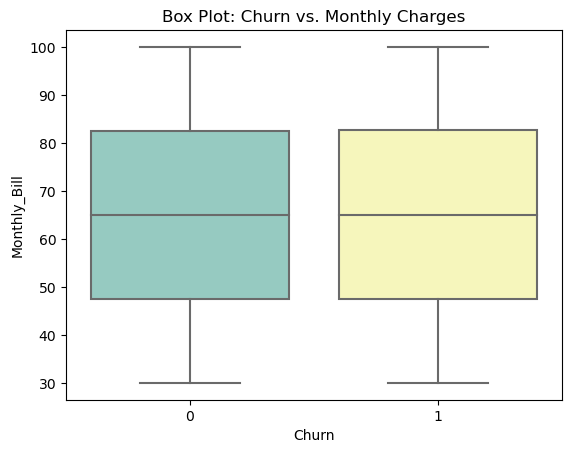

In [16]:
sns.boxplot(x='Churn', y='Monthly_Bill', data=df, palette='Set3')
plt.title('Box Plot: Churn vs. Monthly Charges')
plt.show()

In [17]:
# Split the data 
X = df.drop('Churn', axis=1)
y = df['Churn']

In [18]:
#Identify and Handle Outliers
# Calculate Z-scores for each numerical feature
z_scores = zscore(X.select_dtypes(include=['float64', 'int64']))

# Define a Z-score threshold for outlier detection
z_score_threshold = 3

# Identify outlier indices
outlier_indices = (z_scores > z_score_threshold).any(axis=1)

# Handle outliers by capping values to a specified percentile
max_cap = X.select_dtypes(include=['float64', 'int64']).quantile(0.95)
X_capped = X.copy()
X_capped.loc[outlier_indices, X.select_dtypes(include=['float64', 'int64']).columns] = max_cap

In [19]:
#Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_capped, y, test_size=0.2, random_state=42)

In [20]:
#Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=['float64', 'int64']))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=['float64', 'int64']))

In [21]:
# Encode Categorical Features
# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns

In [24]:
# Use ColumnTransformer to apply scaling and encoding simultaneously
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [25]:
# Initialize Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42)

In [26]:
# Define hyperparameters and parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [27]:
# Initialize GridSearchCV
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to training data
grid_search.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [28]:
# Get best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_rf_model.predict(X_test_preprocessed)

In [29]:
# Display Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Display Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[5799 4280]
 [5664 4257]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.58      0.54     10079
           1       0.50      0.43      0.46      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000

